# Урок 6. Градиентный бустинг

В этом уроке мы продолжаем тему ансамблей алгоритмов, рассматривая еще один их вид - _градиентный бустинг_. 

\
-\7\714споминая тему предыдущего урока, случайные леса, напомним, что случайный лес - это ансамбль деревьев небольшой глубины, строящихся независимо друг от друга. В независимости построения деревьев кроется и плюс и минус алгоритма: с одной стороны, построение деревьев можно распараллеливать и, например, организовывать на разных ядрах процессора, с другой стороны, следствием их независимости является тот факт, что для решения сложных задач требуется очень большое количество деревьев. В этих случаях случаях (при большой выборке или большом количестве признаков) обучение случайного леса может требовать очень много ресурсов, а если для ограничения их потребления слишком ограничивать глубину деревьев, они могут не уловить все закономерности в данных и иметь большой сдвиг (и, следовательно, ошибку).

Бустинг является своеобразным решением этой проблемы: он заключается в последовательном построении ансамбля, когда деревья строятся одно за другим, и при этом каждое следующее дерево строится таким образом, чтобы исправлять ошибки уже построенного на данный момент ансамбля. При таком подходе базовые алгоритмы могут быть достаточно простыми, то есть можно использовать неглубокие деревья.

## Алгоритм градиентного бустинга (GBM)

Итоговый алгоритм ищется в виде взвешенной суммы базовых алгоритмов (обратите внимание: не среднего, а суммы):

$$a_{N}(x) = \sum^{N}_{n=1}\gamma_{n}b_{n}(x).$$

В случае линейной регрессии задача состоит в минимизации среднеквадратичного функционала ошибки:

$$\frac{1}{l}\sum_{i=1}^{l}(a(x_{i}) - y_{i})^{2} \rightarrow \text{min}.$$

Так как ансамбль строится итеративно, нужно вначале обучить первый простой алгоритм:

$$b_{1}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - y_{i})^{2}.$$

Как мы помним, такая задача легко решается методом градиентного спуска.

После того, как мы нашли первый алгоритм $b_{1}(x)$, нам нужно добавить в ансамбль еще один алгоритм $b_{2}(x)$. Для начала найдем разницу ответов первого алгоритма с реальными ответами:

$$s_{i}^{(1)} = y_{i} - b_{1}(x_{i}).$$

Если прибавить эти значения к полученным предсказаниям, получим идеальный ответ. Таким образом, новый алгоритм логично обучать так, чтобы его ответы были максимально близки к этой разнице, чтобы при их прибавлении к ответам первого алгоритма мы получили близкие к реальным. Значит, второй алгоритм будет обучаться на следующем функционале ошибки:

$$b_{2}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(1)})^{2} = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - (y_{i} - b_{1}(x_{i})))^{2}.$$

Каждый следующий алгоритм также настраивается на остатки композиции из предыдущих алгоритмов:

$$b_{N}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(N)})^{2},$$ 

$$s_{i}^{(N)} = y_{i} - \sum_{n=1}^{N-1}b_{n}(x_{i}) = y_{i} - a_{N-1}(x_{i}).$$

Таким образом, каждый новый алгоритм корректирует ошибки предыдущих, и так продолжается до момента получения приемлемой ошибки на композиции. Вектор коэффициентов $s$ при этом называют _вектором сдвига_.

Выбор сдвига из условия $s_{i} = y_{i} - a_{N-1}(x_{i})$ требует точного совпадения полученных предсказаний и ответов, однако, в более общем случае вектор сдвига принимают с учетом особенностей используемой в данном случае функции потерь: вектор сдвига должен ее минимизировать, то есть направлять в сторону уменьшения. Как мы помним из метода градиентного спуска, направление наискорейшего убывания функции совпадает с ее антиградиентом. Таким образом, если при обучении мы минимизируем функционал ошибки $L(y,z)$

$$\sum_{i=1}^{l}L(y_{i}, a_{N-1}(x_{i}) + s_{i}) \rightarrow \underset{s}{\text{min}},$$

сдвиг на каждом шаге должен быть противоположен производной функции потерь в точке $z = a_{N-1}(x_{i})$. 

$$s_{i} = \left.-\frac{\partial L}{\partial z} \right|_{z = a_{N-1}(x_{i})}.$$

Каждый новый алгоритм таким образом выбирается так, чтобы как можно лучше приближать антиградиент ошибки на обучающей выборке. 

После того, как мы вычислили требуемый для минимизации ошибки сдвиг $s$, нужно настроить алгоритм $b_{N}(x)$ так, чтобы он давал максимально близкие к нему ответы, то есть обучать его именно на вектор сдвига. Близость ответов алгоритма к сдвигу обычно оценивается с помощью среднеквадратичной ошибки независимо от условий исхожной задачи (так как исходно используемая функция потерь $L$ уже учтена в сдвигах $s_{i}$):

$$b_{N}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2}.$$

Коэффициент $\gamma$ для найденного алгоритма также находится по аналогии с наискорейшим градиентным спуском:

$$\gamma_{N} = \underset{\gamma}{\text{argmin}}\sum_{i=1}^{l}L(y_{i},a_{N-1}(x_{i}) + \gamma b_{N}(x_{i})).$$

Обычно в качестве функции потерь в задачах регрессии принимается квадратичная функция потерь ($L_{2}$ loss):

$$L(y, z) = (y-z)^{2},$$

его производная по $z$ примет вид 

$$L'(y, z) = 2(z-y)$$

или модуль отклонения ($L_{1}$ loss)

$$L(y, z) = |y-z|,$$

его производная по $z$ будет иметь вид 

$$L'(y, z) = \text{sign}(z-y).$$

В случае классификации - логистическая функция потерь:

$$L(y, z) = log(1 + exp(-yz))$$

ее производная:

$$L'(y, z) = \frac{y_{i}}{1+exp(-yz)}.$$

Следует помнить, что компоненты $s_{i}$, вычисляемые через эти производные, берутся с минусом.

Аналогично алгоритму градиентного спуска, имеет смысл добавлять ответ каждого нового алгоритма не полностью, а с некоторым шагом $\eta \in (0, 1]$, так как базовые алгоритмы обычно достаточно простые (например, деревья малой глубины), и они могут плохо приближать вектор антиградиента, и тогда вместо приближения к минимуму мы будем получать случайное блуждание в пространстве. В градиентном бустинге такой прием называется сокращением шага.

$$a_{N}(x) = a_{N-1}(x) + \eta \gamma_{N} b_{N}(x).$$

Градиентный бустинг склонен к переобучению при увеличении числа итераций $N$ или глубины входящих в него деревьев. Стоит об этом помнить при построении алгоритма и выбирать оптимальные параметры по отложенной выборке или с помощью кросс-валидации.

В конечном итоге алгоритм построения модели градиентного бустинга заключается в следующих шагах:

__1.__ Для инициализации выбирается произвольный простой алгоритм $b_{0}(x)$, в его роли можно брать обычные константные алгоритмы: в случае задачи регрессии это может быть

$$b_{0}(x) = 0$$

или среднее значение по всем объектам обучающей выборки 

$$b_{0}(x) = \frac{1}{l}\sum_{i=1}^{l}y_{i};$$

в случае классификации - самый часто встречающийся в выборке класс

$$b_{0}(x) = \underset{y}{\text{argmax}}\sum_{i=1}^{l}[y_{i} = y].$$

__2.__ Для каждой итерации вычисляется вектор сдвига $s$:

$$s = \left ( \left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{1})},...,\left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{l})}\right );$$

находится алгоритм

$$b_{n}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2};$$

находится оптимальный коэффициент $\gamma$

$$\gamma_{n} = \underset{\gamma}{\text{argmin}}\sum_{i=1}^{l}L(y_{i},a_{n-1}(x_{i}) + \gamma b_{n}(x_{i})).$$

и добавляется в имеющийся ансамбль с умножением на шаг $\eta$, называемый _скоростью обучения_ (опционно)

$$a_{n}(x) = a_{n-1}(x) + \eta \gamma_{n} b_{n}(x).$$

__3.__ При достижении критериев остановки компонуется итоговая модель.

### Стохастический градиентный бустинг

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

## Реализация алгоритма градиентного бустинга

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [52]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [53]:
from sklearn.datasets import load_diabetes

In [54]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [55]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [56]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [57]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [58]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [59]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [60]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [61]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [62]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1284.3125949128969
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 3706.173245618937


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа 

---

итераций.

In [63]:
import matplotlib.pyplot as plt

In [64]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

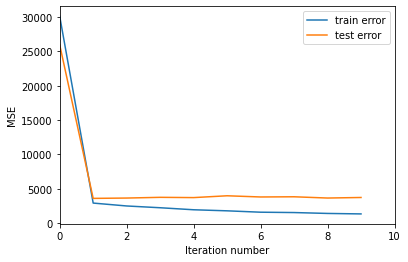

In [65]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [66]:
n_trees = 10
coefs = [1] * n_trees

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [67]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1284.3125949128969
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 3706.173245618937


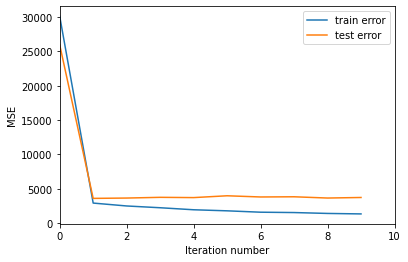

In [68]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [69]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1284.3125949128969
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 3706.173245618937


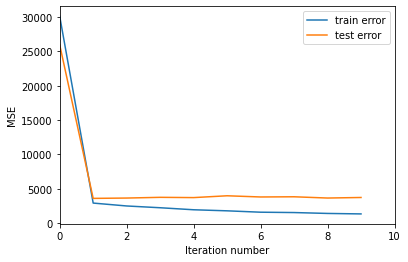

In [70]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [71]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [72]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 25155.047406491056
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 21740.003317301842


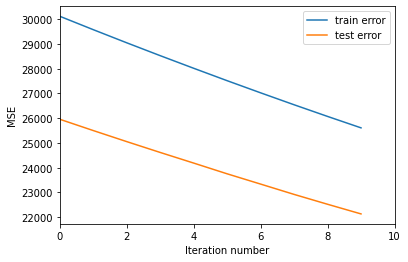

In [73]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [74]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [75]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 4834.128158882089
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 5636.8740702516025


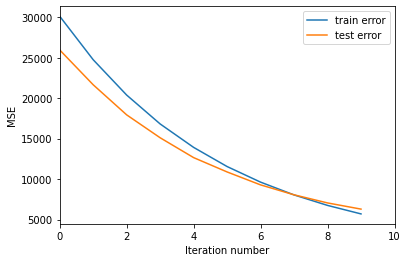

In [76]:
get_error_plot(n_trees, train_errors, test_errors)

Ошибка на обучающей выборке упала, а на тестовой несколько поднялась, то есть в данном случае можем говорить о появлении переобучения.

В целом, тут мы показали, что варьируя параметры обучения градиентного бустинга можно добиваться различного уровня точности модели.

Существуют различные реализации градиентного бустинга, и одна из самых популярных и широко используемых - XGBoost (в Python содержится в библиотеке с аналогичным названием). С этой реализацией можно ознакомиться в дополнительных материалах.

## AdaBoost

Алгоритм AdaBoost (Adaptive boosting) также в настоящее время является одним из подвидов градиентного бустинга, однако фактически он является своего рода "предшественником" алгоритма градиентного бустинга, после разработки которого став его частным случаем.

Для задачи бинарной классификации он заключается в использовании слабых классификаторов (например, деревьев глубиной 1 - так называемых "пней") в цикле, с придаванием объектам весов. После каждого шага итерации, когда разделяющая плоскость классификатора делит пространство объектов на две части, веса объектов перераспределяются, и веса неправильно классифицированных объектов увеличиваются, чтобы на следующей итерации классификатор акцентировался на этих объектах. Классификатору также присваивается вес в зависимости от его точности. Затем полученные деревья с весами объединяются в один сильный классификатор. В этом и заключается адаптивность алгоритма. Алгоритм AdaBoost также называют алгоритмом усиления классификаторов.

Таким образом, его алгоритм заключается в следующем:

__1.__ Инициализация начальных весов объектов из выборки длиной $l$:

$$D_{1}(i) = \frac{1}{l}$$

__2.__ Для каждого из $N$ деревьев в ансамбле:

- находим классификатор $b_{n}$, который минимизирует взвешенную ошибку классификации

$$b_{n} = \underset{b}{\text{argmin}}\;\varepsilon_{j},$$

    где 

$$\varepsilon_{j} = \sum_{i=1}^{l}D_{n}(i)[y_{i}\neq b_{j}(x)]$$

- критерием остановки является значение $\varepsilon_{j} \geq 0.5$. При таком значении ошибки нужно выбрать другой классификатор и продолжить.

- выбираем вес для дерева $\alpha_{n}$ по формуле

$$\alpha_{n} = \frac{1}{2}\text{ln}\frac{1 - \varepsilon_{n}}{\varepsilon_{n}}$$

- обновляем веса при объектах:

$$D_{n+1}(i) = \frac{D_{n}(i)e^{-\alpha_{n}y_{i}b_{n}(x_{i})}}{Z_{n}},$$

выражение $y_{i}b_{n}(x_{i})$ в случае $Y = \{-1, 1\}$ будет равняться 1 для правильно классифицированных объектов и -1 для неправильно классифицированных, то есть по сути правильность классификации будет означать, будет $e^{\alpha_{n}}$ стоять в числителе или в знаменателе формулы. В случае $Y = \{0,1\}$ вес будет уменьшаться у неправильно классифицированных объектов, а у неправильно классифицированных - оставаться неизменным (до нормализации). $Z_{n}$ здесь - нормализующий параметр, выбираемый так, чтобы $D_{n+1}$ по своей сути являлся распределением вероятностей, то есть

$$\sum_{i=1}^{l}D_{n+1} = 1.$$

__3.__ Строим получившуюся модель

$$a(x) = \text{sign}\left( \sum_{n=1}^{N}\alpha_{n}b_{n}(x) \right).$$

Напишем его простую реализацию.

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [42]:
X, y = load_breast_cancer(return_X_y=True)

Разделим выборку на обучающую и тестовую

In [43]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Реализуем функцию подсчета ошибки

In [44]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

И сам алгоритм

In [45]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

Обучим алгоритм из 50 деревьев

In [46]:
N = 50

models = adaboost(X_train, y_train, N)

Теперь осуществим предсказание

In [47]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 99.061


In [48]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 95.105


Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.

In [49]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

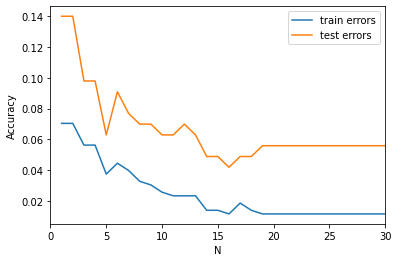

In [50]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

Достоинствами алгоритма AdaBoost можно назвать простоту реализации, хорошую обобщающую способность и небольшую вычислительную сложность. В то же время, есть и недостатки - в первую очередь, склонность к переобучению при наличии в данных шума и выбросов: для наиболее трудноклассифицируемых объектов алгоритм будет определять очень большие веса и в итоге переобучаться на них. В то же время это является и плюсом: таким образом можно идентифицировать выбросы. 

## Дополнительные материалы

1. [Интерактивная демонстрация градиентного бустинга](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
2. [sklearn.datasets](https://scikit-learn.org/stable/datasets/index.html)
3. [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
4. [$L_{1}$ loss и $L_{2}$ loss](https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions)
5. [XGBoost](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)
6. [AdaBoost](https://ru.wikipedia.org/wiki/AdaBoost)

1) Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

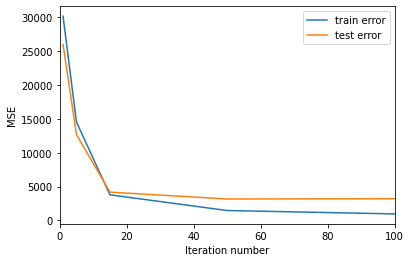

In [85]:
n_trees = [1, 5, 15, 50, 100]


max_depth = 3

eta = 0.1

train_err = []
test_err = []

for i in n_trees:
  coefs = [1] * i
  trees, train_errors, test_errors = gb_fit(i, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
  train_err.append(train_errors[-1])
  test_err.append(test_errors[-1])

def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees[-1])
    plt.plot(n_trees, train_err, label='train error')
    plt.plot(n_trees, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

get_error_plot(n_trees, train_err, test_err)

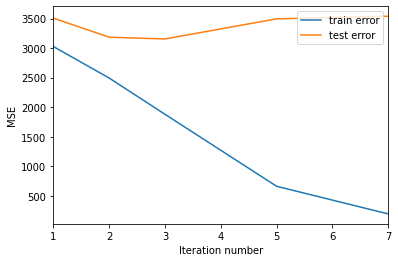

In [87]:
n_trees = 30
coefs = [1] * n_trees

max_depth = [1, 2, 3, 5, 7]

eta = 0.1

train_err = []
test_err = []

for i in max_depth:
  
  trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
  train_err.append(train_errors[-1])
  test_err.append(test_errors[-1])

def get_error_plot(max_depth, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(max_depth[0], max_depth[-1])
    plt.plot(max_depth, train_err, label='train error')
    plt.plot(max_depth, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

get_error_plot(max_depth, train_err, test_err)

При увеличении количества деревьев в ансамбле, сначало происходит резкое уменьшее ошибки, но потом уменьшение MSE замедляется и наченает рости разница между ошибками на обучающей и тестовой выборками (что сведетельствует о переобучении). При увеличении максимальной глубины дерева MSE на тренировочной выборки постояно падает, но на тестовой выбоки ошибка падает только в начале, а дальше проиходит рост(что является признаком сильного переобучения)